# **Bike Sharing Demand**

## **Forecast use of a city bikeshare system**
https://www.kaggle.com/competitions/bike-sharing-demand

## **Mission : 각 시간 동안 대여된 자전거의 총 수를 예측**

### **평가지표: RMSLE**
#### $$ \sqrt{\frac{1}{n} \sum_{i=1}^n \left( \log_{} (p_{i} + 1) - \log_{} (a_{i} + 1) \right)^2 }  $$

#### $$ n \ : \ the \ number \ of \ hours \ in \ the \ test \ set $$

#### $$ p_{i} \ : \ your \ predicted \ count  $$

#### $$ a_{i} \ : \ the \ actual \ count  $$

#### $$ log(x) \ : \ the \ natural \ logarithm  $$

### **문제유형: 회귀**

#### **사용 모델 : RandomForest Model**

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

from sklearn.metrics import accuracy_score
from sklearn.metrics import log_loss

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import PowerTransformer

In [2]:
train = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\train.csv")
test = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\test.csv")
submission = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\sampleSubmission.csv")

In [3]:
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    10886 non-null  object 
 1   season      10886 non-null  int64  
 2   holiday     10886 non-null  int64  
 3   workingday  10886 non-null  int64  
 4   weather     10886 non-null  int64  
 5   temp        10886 non-null  float64
 6   atemp       10886 non-null  float64
 7   humidity    10886 non-null  int64  
 8   windspeed   10886 non-null  float64
 9   casual      10886 non-null  int64  
 10  registered  10886 non-null  int64  
 11  count       10886 non-null  int64  
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.7+ KB


In [5]:
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   datetime    6493 non-null   object 
 1   season      6493 non-null   int64  
 2   holiday     6493 non-null   int64  
 3   workingday  6493 non-null   int64  
 4   weather     6493 non-null   int64  
 5   temp        6493 non-null   float64
 6   atemp       6493 non-null   float64
 7   humidity    6493 non-null   int64  
 8   windspeed   6493 non-null   float64
dtypes: float64(3), int64(5), object(1)
memory usage: 456.7+ KB


In [7]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   datetime  6493 non-null   object
 1   count     6493 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 101.6+ KB


In [8]:
def resumetable(df):
  print(f'데이터셋 형상: {df.shape}')
  summary = pd.DataFrame(df.dtypes, columns=['데이터 타입'])
  summary = summary.reset_index()
  summary = summary.rename(columns={'index': '피처 값'})
  summary['결측값 개수'] = df.isnull().sum().values
  summary['고윳값 개수'] = df.nunique().values
  summary['첫 번째 값'] = df.loc[0].values
  summary['두 번째 값'] = df.loc[1].values
  return summary

summary1 = resumetable(train)
summary2 = resumetable(test)

데이터셋 형상: (10886, 12)
데이터셋 형상: (6493, 9)


In [9]:
summary1

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,datetime,object,0,10886,2011-01-01 00:00:00,2011-01-01 01:00:00
1,season,int64,0,4,1,1
2,holiday,int64,0,2,0,0
3,workingday,int64,0,2,0,0
4,weather,int64,0,4,1,1
5,temp,float64,0,49,9.84,9.02
6,atemp,float64,0,60,14.395,13.635
7,humidity,int64,0,89,81,80
8,windspeed,float64,0,28,0.0,0.0
9,casual,int64,0,309,3,8


In [10]:
summary2

,피처 값,데이터 타입,결측값 개수,고윳값 개수,첫 번째 값,두 번째 값
0,datetime,object,0,6493,2011-01-20 00:00:00,2011-01-20 01:00:00
1,season,int64,0,4,1,1
2,holiday,int64,0,2,0,0
3,workingday,int64,0,2,1,1
4,weather,int64,0,4,1,1
5,temp,float64,0,49,10.66,10.66
6,atemp,float64,0,65,11.365,13.635
7,humidity,int64,0,79,56,56
8,windspeed,float64,0,27,26.0027,0.0


## **feature 알아보기**

- 01. datetime	
    - 시계열 데이터 -> 연도, 월, 일, 시간, 분, 피쳐 추가 생성 필요
    - type : object
  

- 02. season
    - 계절
    - 종류 : 1 = spring, 2 = summer, 3 = fall, 4 = winter  
    - type : int64
  

- 03. holiday
    - 주말, 공휴일
    - type : int64
  

- 04. workingday
    - 평일
    - type : int64
  

- 05. weather
    - 날씨
    - 종류
        - 1: Clear, Few clouds, Partly cloudy, Partly cloudy
        - 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mistt
        - 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
        - 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
    - type : int64
  

- 06. temp
    - 온도
    - type : float64
  

- 07. atemp
    - 체감 온도
    - type : float64
  

- 08. humidity
    - 습도
    - type : int64
  

- 09. windspeed
    - 풍속
    - type : float64
  

- 10. casual
    - test data에 없는 데이터이므로 제거
    - type : int64
  

- 11. registered	
    - test data에 없는 데이터이므로 제거
    - type : int64
  

- 12. count	
    - 자전거 대여 수(타겟 변수)
    - type : int64
  

## **EDA**

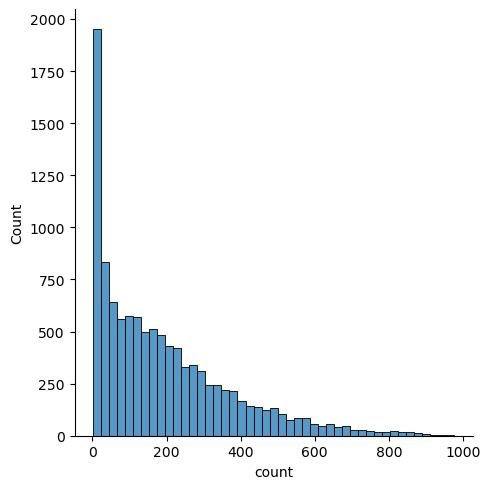

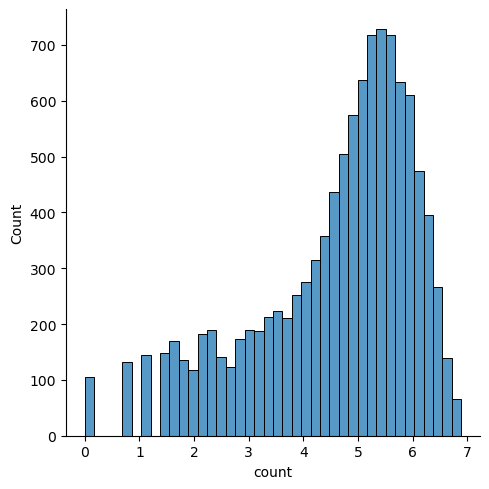

In [11]:
# 1. 타깃값 count의 분포 (수치형 데이터)

mpl.rc('font', size=10)
sns.displot(train['count']) 

# 회귀 모델이 좋은 성능을 내기 위해서는 정규분포를 따라야 하므로 로그변환을 취한다.
sns.displot(data= train, x = np.log(train['count']))

# 타깃값을 log(count)로 변환해 사용 후 마지막에 지수 변환

In [12]:
# 2. datetime
# 데이터 타입이 object이므로 이를 범주형 변수로 변환

# datetime을 공백을 기준으로 자르면 날짜와 시간으로 나눌 수 있다.
# 날짜는 다시 년 월 일로 나눌 수 있다.
# 시간은 다시 시 분 초

# 피처 생성
# 날짜
train['date'] = train['datetime'].apply(lambda x: x.split()[0])
# 년
train['year'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월
train['month'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 일
train['day'] = train['datetime'].apply(lambda x: x.split()[0].split('-')[2])
# 시
train['hour'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 분
train['minute'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[1])
# 초
train['second'] = train['datetime'].apply(lambda x: x.split()[1].split(':')[2])

# 요일 피쳐 생성
from datetime import datetime
import calendar

# 0: 월요일 ~ 6: 일요일
train['weekday'] = train['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())

# date 피쳐 제거  : year month day가 있으므로
# datetime 피쳐는 인덱스 역할만 하므로 제거
# month는 season으로 대체 가능하므로 추후 제거
# minute, second 모두 0이므로 제거

<Axes: xlabel='second', ylabel='count'>

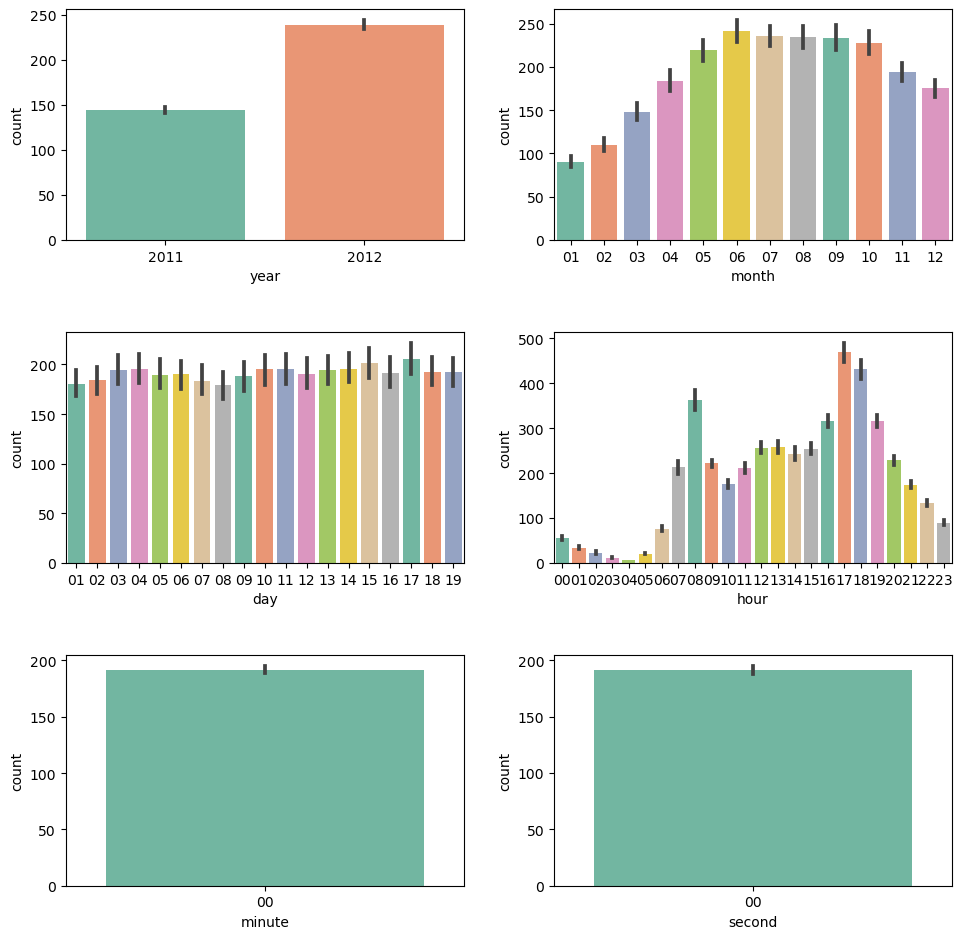

In [13]:
# barplot 시각화
mpl.rc('font', size=10)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(3, 2) # 3행 2열
plt.tight_layout()
figure.set_size_inches(10,10)

sns.barplot(x='year', y='count', data=train, palette='Set2', ax=axes[0,0])
# 2012년의 대여수량이 더 많다.
sns.barplot(x='month', y='count', data=train, palette='Set2', ax=axes[0,1])
# 가을 > 여름 > 겨울 > 봄
sns.barplot(x='day', y='count', data=train, palette='Set2', ax=axes[1,0])
# day별 차이가 없으므로 day 피쳐 추후 제거
sns.barplot(x='hour', y='count', data=train, palette='Set2', ax=axes[1,1])
# 아침 시간 저조 / 출 퇴근시간에 많음
sns.barplot(x='minute', y='count', data=train, palette='Set2', ax=axes[2,0])
# 의미 없음 추후 제거
sns.barplot(x='second', y='count', data=train, palette='Set2', ax=axes[2,1])
# 의미 없음 추후 제거

<Axes: xlabel='hour', ylabel='count'>

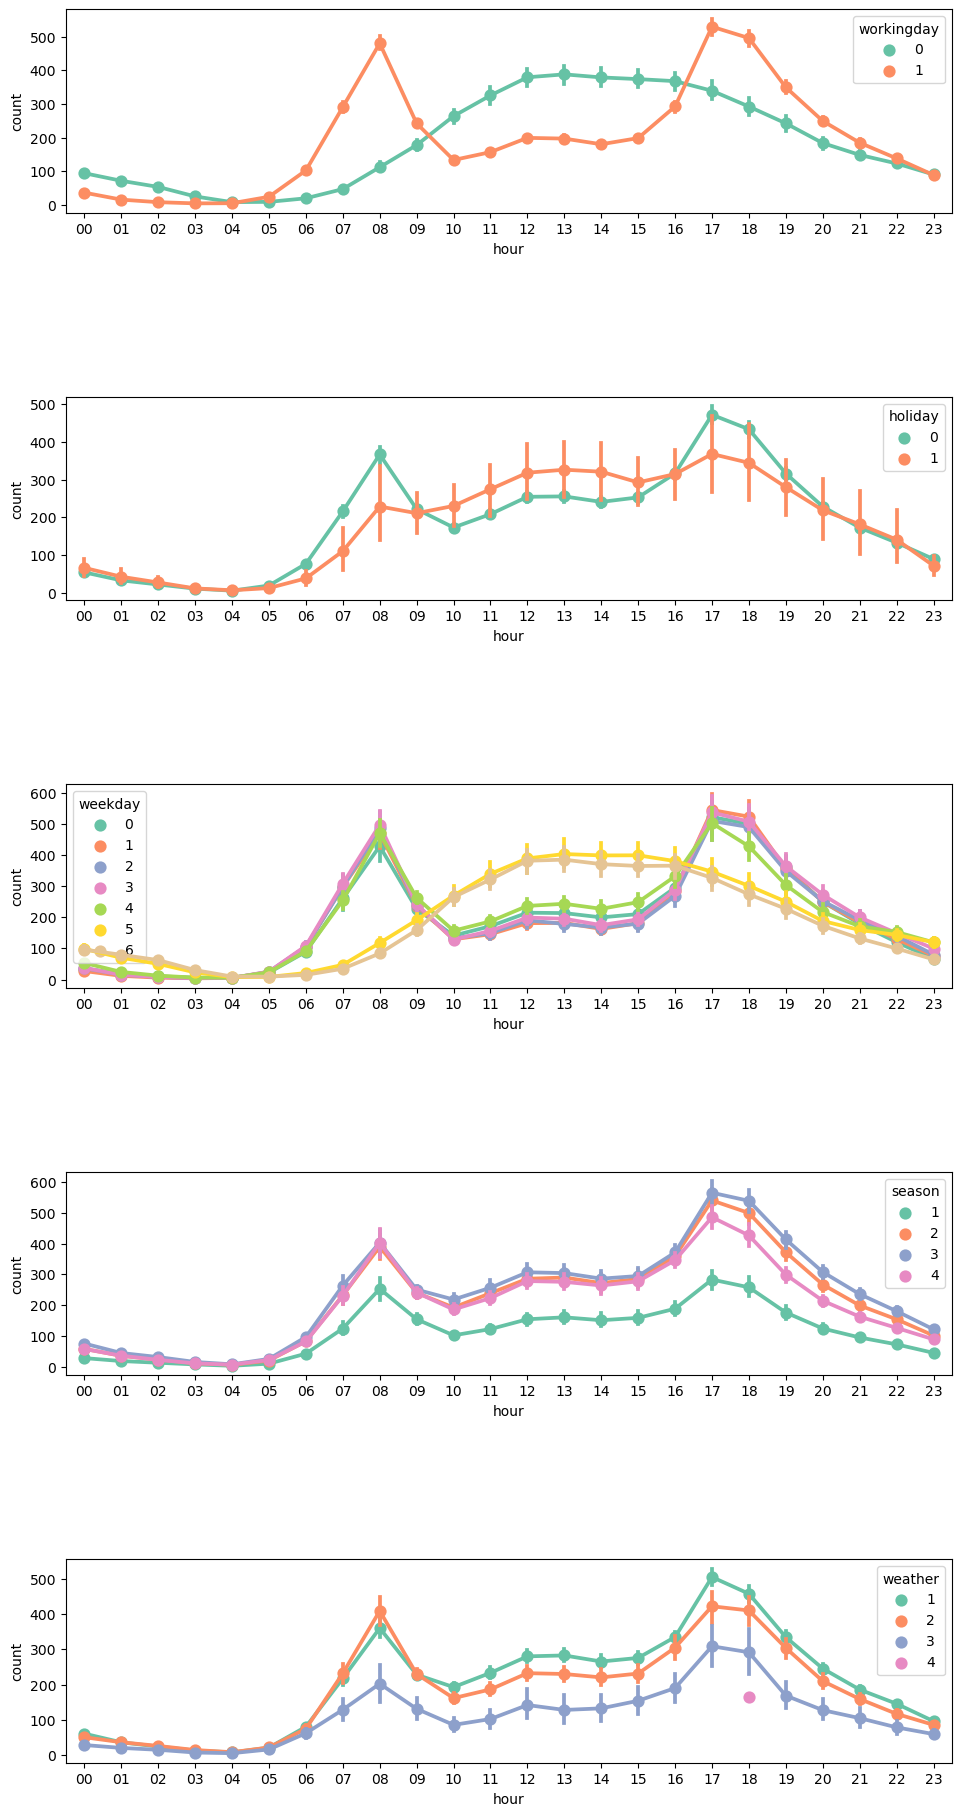

In [14]:
# point plot 시각화 
mpl.rc('font', size=10)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(5, 1) # 1행 3열
plt.tight_layout()
figure.set_size_inches(10,20)

sns.pointplot(x='hour', y='count', data=train, hue='workingday', palette='Set2', ax=axes[0])
sns.pointplot(x='hour', y='count', data=train, hue='holiday', palette='Set2', ax=axes[1])
sns.pointplot(x='hour', y='count', data=train, hue='weekday', palette='Set2', ax=axes[2])
sns.pointplot(x='hour', y='count', data=train, hue='season', palette='Set2', ax=axes[3])
sns.pointplot(x='hour', y='count', data=train, hue='weather', palette='Set2', ax=axes[4])
# weaather == 4인 데이터 제거(이상치 제거)

<Axes: xlabel='season', ylabel='count'>

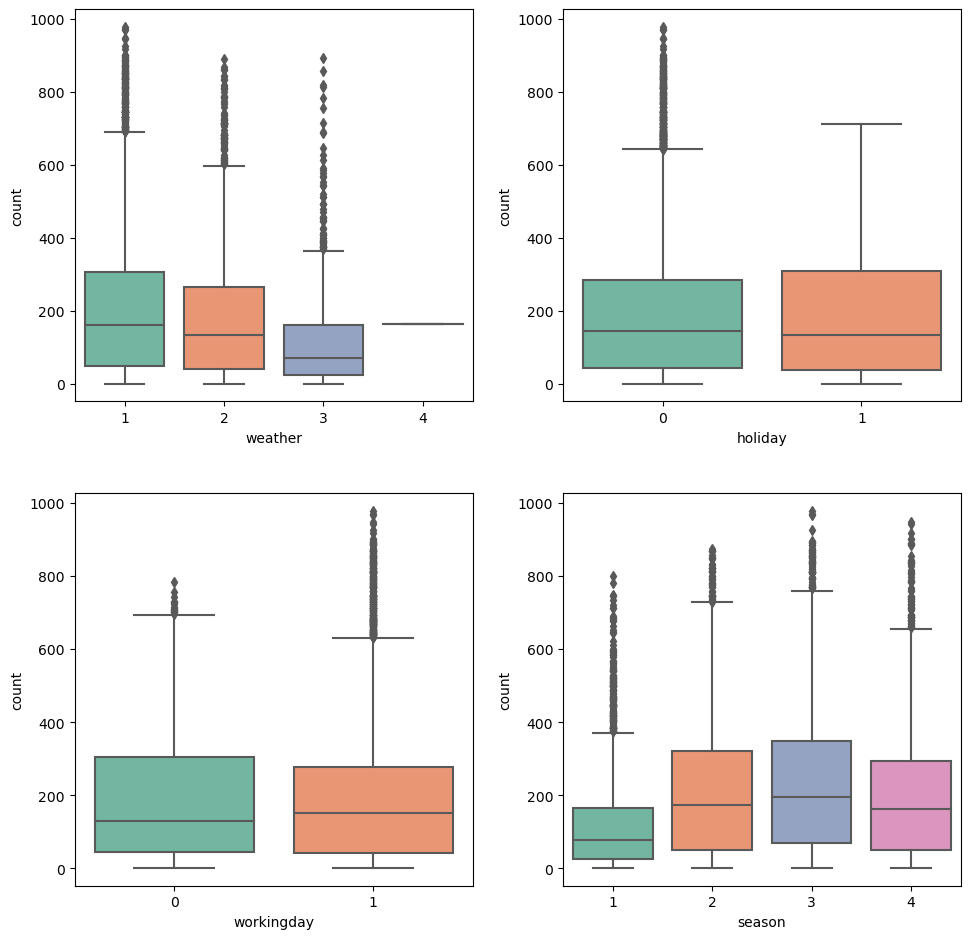

In [15]:
# 2-3 boxplot 시각화 
# 계절, 날씨, 공휴일, 근무일별 대여 수량 시각화
mpl.rc('font', size=10)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(2, 2) # 1행 3열
plt.tight_layout()
figure.set_size_inches(10,10)

sns.boxplot(x='weather', y='count', data=train, palette='Set2', ax=axes[0,0])
# 날씨가 좋을 수록 대여량 증가
sns.boxplot(x='holiday', y='count', data=train, palette='Set2', ax=axes[0,1])
# 비슷하나 공휴일이 아닐 때 이상치 존재
sns.boxplot(x='workingday', y='count', data=train, palette='Set2', ax=axes[1,0])
# 비슷하나 이상치 존재
sns.boxplot(x='season', y='count', data=train, palette='Set2', ax=axes[1,1])
# 가을 여름 겨울 봄 순 / 이상치 존재

<Axes: xlabel='windspeed', ylabel='count'>

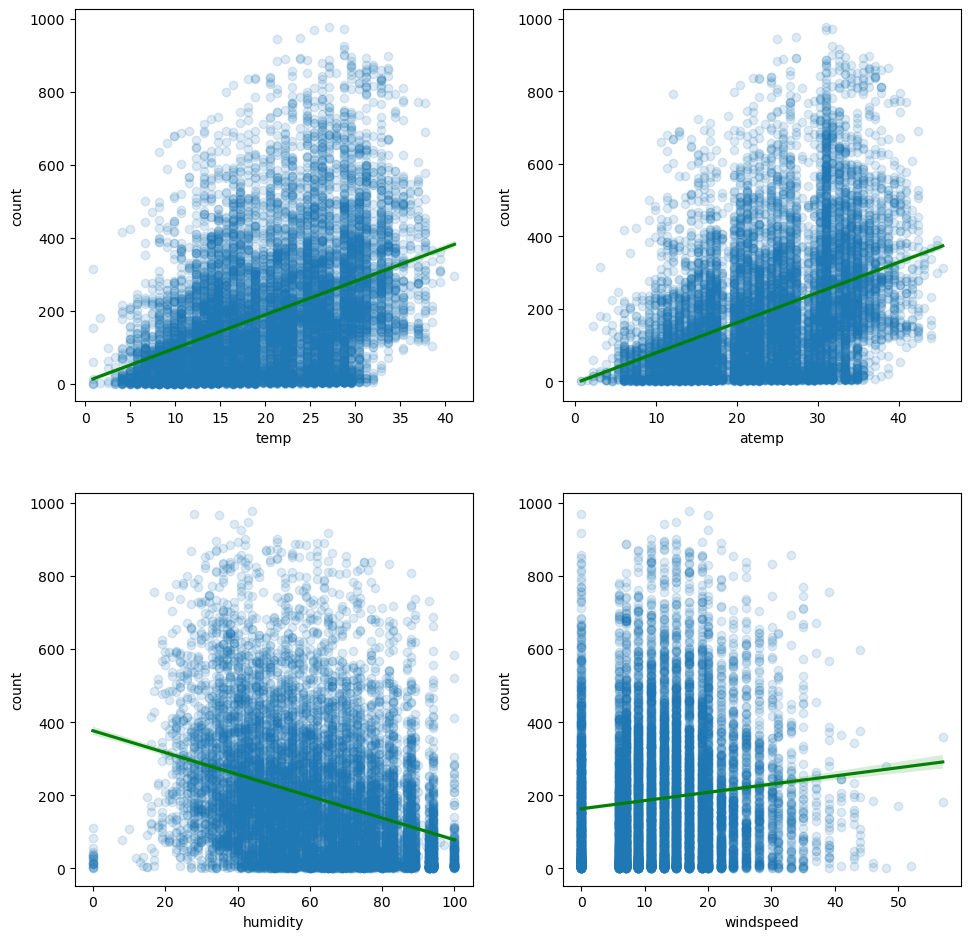

In [16]:
# regplot
# 온도, 체감온도, 풍속, 습도별 대여 수량 시각화
mpl.rc('font', size=10)
mpl.rc('axes', titlesize=15)
figure, axes = plt.subplots(2, 2) # 1행 3열
plt.tight_layout()
figure.set_size_inches(10,10)

sns.regplot(x='temp', y='count', data=train, ax=axes[0,0],
            scatter_kws={'alpha': 0.15}, line_kws={'color':'green'})
# 온도가 높을 수록 대여수량 증가
sns.regplot(x='atemp', y='count', data=train, ax=axes[0,1],
            scatter_kws={'alpha': 0.15}, line_kws={'color':'green'})
# 체감 온도가 높을수록 대여수량 증가
sns.regplot(x='humidity', y='count', data=train, ax=axes[1,0],
            scatter_kws={'alpha': 0.15}, line_kws={'color':'green'})
# 습도가 낮을 수록 대여수량 증가
sns.regplot(x='windspeed', y='count', data=train, ax=axes[1,1],
            scatter_kws={'alpha': 0.15}, line_kws={'color':'green'})
# 풍속이 셀수록 대여수량 증가 -> 이상? 0으로 결측값이 많기 때문이다.
# 다른 값으로 대체 불가능하니 windspeend 피쳐는 제거

<Axes: >

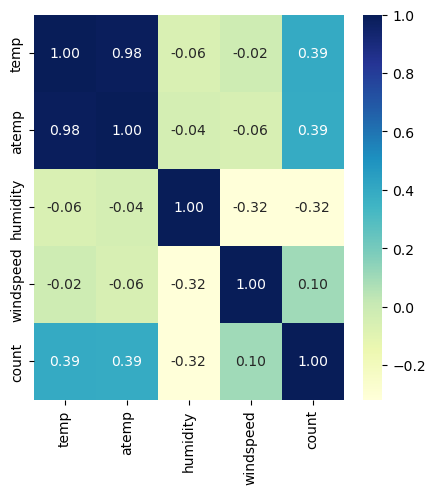

In [17]:
# heatmap
# 수치형 변수 간 히트맵(상관 관계 분석)

corrMatrix = train[['temp', 'atemp', 'humidity','windspeed','count']].corr()
fig, ax = plt.subplots()
fig.set_size_inches(5,5)
sns.heatmap(corrMatrix, annot=True, cmap='YlGnBu', fmt='.2f') 
# windspeed와 count와의 상관계수가 낮으므로 제거

## **Feature 분석 정리**

- 1. 타깃값 로그 변환 마지막에 지수변환 필요
- 2. 시간 관련 변수 추가 
- 3. 요일 변수 추가
- 4. 테스트 데이터에 없는 값 casual, registered 제거
- 5. datetime 필요없음 제거
- 6. date 피쳐 제거 -> year, day, month 있음 
- 7. month는 season을 통해 유추가능하므로 제거 
- 8. day 피쳐는 분별력이 없으므로 제거
- 9. minute, second는 모두 0으로 아무런 정보가 없으므로 제거
- 10. weather의 이상치 값 제거
- 11. windspeend 피쳐 제거 : 대여 수량과의 상관계수가 높고 0으로 결측값이 많으므로 제거

In [18]:
# 데이터를 다시 불러오기 초기화 
train = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\train.csv")
test = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\test.csv")
submission = pd.read_csv(r"C:\Users\degas\Desktop\bike-sharing-demand\sampleSubmission.csv")


In [19]:
# 이상치 제거
train = train[train['weather'] != 4]

In [20]:
# 데이터 합치기
data = pd.concat([train, test], ignore_index=True)

In [21]:
# 파생 피쳐 추가

# 날짜 피처
data['date'] = data['datetime'].apply(lambda x: x.split()[0])
# 년 피처
data['year'] = data['datetime'].apply(lambda x: x.split()[0].split('-')[0])
# 월 피처
data['month'] = data['datetime'].apply(lambda x: x.split()[0].split('-')[1])
# 일 피처
data['day'] = data['datetime'].apply(lambda x: x.split()[0].split('-')[2])
# 시 피처
data['hour'] = data['datetime'].apply(lambda x: x.split()[1].split(':')[0])
# 분 피처
data['minute'] = data['datetime'].apply(lambda x: x.split()[1].split(':')[1])
# 초 피처
data['second'] = data['datetime'].apply(lambda x: x.split()[1].split(':')[2])

# 요일 피처
data['weekday'] = data['date'].apply(lambda x: datetime.strptime(x, "%Y-%m-%d").weekday())

In [22]:
# 필요없는 피처 제거
drop_features = ['datetime', 'windspeed', 'casual', 'registered', 'date', 'month' ]
data = data.drop(drop_features, axis=1)

In [23]:
# 훈련 데이터외 테스트 데이터로 나누기
X_train = data[~pd.isnull(data['count'])]
X_test = data[pd.isnull(data['count'])]

# 타깃값 count 제거
X_train = X_train.drop(['count'], axis=1)
X_test = X_test.drop(['count'], axis=1)

# 타깃값 설정
y = train['count']

print(X_train.shape)
print(X_test.shape)
print(y.shape)

(10885, 13)
(6493, 13)
(10885,)


In [24]:
def rmsle(y_target, y_pred, convertExp=True):
  # 지수변환
  if convertExp:
    # 타깃값
    y_target = np.exp(y_target) 
    # 예측값
    y_pred = np.exp(y_pred)

  # 로그 변환 후 결측값을 0으로 변환
  log_target = np.nan_to_num(np.log(y_target+1))
  log_pred = np.nan_to_num(np.log(y_pred+1))

  # RMSLE 계산
  output = np.sqrt(np.mean((log_target - log_pred)**2))
  return output

In [25]:
# 하이퍼파라미터 최적화 & 모델 훈련
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)

rf = RandomForestRegressor()
rf_params = {'random_state':[42], 'n_estimators': [100, 120, 140]}
grid_rf = GridSearchCV(estimator=rf,
                       param_grid=rf_params,
                       scoring=rmsle_scorer,
                       cv=5)

log_y = np.log(y)
grid_rf.fit(X_train, log_y)
print(grid_rf.best_params_)

{'n_estimators': 140, 'random_state': 42}


In [26]:
preds = grid_rf.best_estimator_.predict(X_train)
print(f'randomforest regressor rmsle : {rmsle(log_y, preds, True):.4f}')

randomforest regressor rmsle : 0.1101


In [27]:
rf_preds = grid_rf.best_estimator_.predict(X_test)

submission['count'] = np.exp(rf_preds)
submission.to_csv('submission.csv',index=False)
submission

,datetime,count
0,2011-01-20 00:00:00,12.718447
1,2011-01-20 01:00:00,5.611654
2,2011-01-20 02:00:00,4.578413
3,2011-01-20 03:00:00,3.457132
4,2011-01-20 04:00:00,2.447941
...,...,...
6488,2012-12-31 19:00:00,215.389376
6489,2012-12-31 20:00:00,176.682683
6490,2012-12-31 21:00:00,103.061980
6491,2012-12-31 22:00:00,99.537628
